In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D, Activation, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.models import Model
import tensorflow_hub as hub
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import seaborn as sns
import random



In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Establecer que TensorFlow use solo la memoria que necesita en la GPU, y no la reserve toda
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No se encontraron GPUs. Se utilizará la CPU.")

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Cargamos los datos del drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def unzip_file(zip_path, extract_to):
    """
    Descomprime un archivo ZIP.

    :param zip_path: Ruta al archivo ZIP.
    :param extract_to: Directorio donde se extraerán los archivos.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)



In [ ]:
#Carga de datos
# Ruta al archivo ZIP
zip_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/DL_UNIMIB2016.zip'

# Directorio donde quieres extraer los archivos
extract_to = '/content/data'

# Crear el directorio si no existe
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Descomprimir el archivo
unzip_file(zip_path, extract_to)

print(f"Archivos extraídos en: {extract_to}")

Archivos extraídos en: /content/data


In [ ]:
# Rutas a la carpeta de imágenes y al archivo CSV
#image_folder_path = 'data/UNIMIB2016/images'
#csv_file_path = 'data/UNIMIB2016/percentage.csv'

image_folder_path = 'data/UNIMIB2016/images'
csv_file_path = 'data/UNIMIB2016/percentage.csv'

In [ ]:
# Preparar los datos de imagen
def load_images(filenames, path = image_folder_path):
    loaded_images = []
    for filename in filenames:
        img_path = os.path.join(path, filename)
        print(img_path)
        img = image.load_img(img_path, target_size=(224, 224))  # Ajusta el tamaño según sea necesario
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        loaded_images.append(img_array)
    return np.vstack(loaded_images)

### Split data

En esta seccion se separan en los diferentes conjuntos. Uno de entrenamiento, uno de validación y uno de test. Manteniendo la distribución inicial de los datos.

In [ ]:
# Divide primero en entrenamiento
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['food_pixels'])

# Divide el conjunto temporal en validación y prueba
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['food_pixels'])


In [ ]:
train_df = pd.read_parquet('data/train_df.parquet')
val_df = pd.read_parquet('data/val_df.parquet')
test_df = pd.read_parquet('data/test_df.parquet')

#df_augmented = pd.read_parquet('data/df_augmented.parquet')

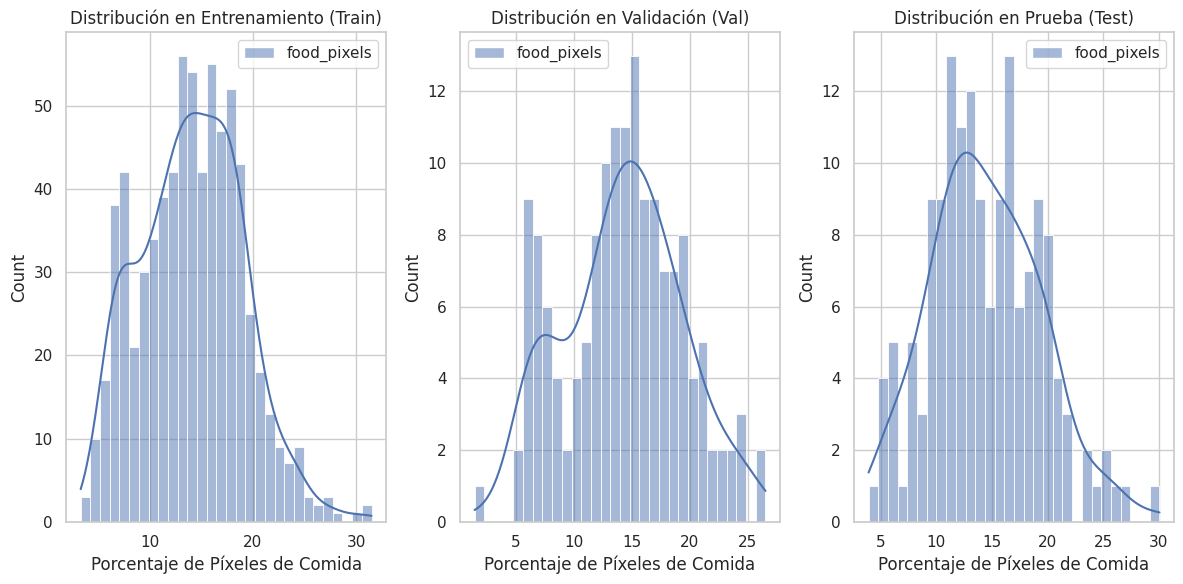

In [ ]:
# Configuración de Seaborn
sns.set(style="whitegrid")

# Crear un gráfico de histograma para cada conjunto de datos
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(train_df, kde=True, bins=30)
plt.title('Distribución en Entrenamiento (Train)')
plt.xlabel('Porcentaje de Píxeles de Comida')

plt.subplot(1, 3, 2)
sns.histplot(val_df, kde=True, bins=30)
plt.title('Distribución en Validación (Val)')
plt.xlabel('Porcentaje de Píxeles de Comida')

plt.subplot(1, 3, 3)
sns.histplot(test_df, kde=True, bins=30)
plt.title('Distribución en Prueba (Test)')
plt.xlabel('Porcentaje de Píxeles de Comida')

plt.tight_layout()
plt.show()


In [ ]:
# Comprobar las proporciones
train_size = train_df.shape[0]
val_size = val_df.shape[0]
test_size = test_df.shape[0]
total_size = train_size + val_size + test_size

train_percentage = (train_size / total_size) * 100
val_percentage = (val_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Imprimir los resultados
print(f"Porcentaje de Entrenamiento (Train): {train_percentage:.2f}%")
print(f"Porcentaje de Validación (Val): {val_percentage:.2f}%")
print(f"Porcentaje de Prueba (Test): {test_percentage:.2f}%")

Porcentaje de Entrenamiento (Train): 69.91%
Porcentaje de Validación (Val): 15.00%
Porcentaje de Prueba (Test): 15.09%


In [ ]:
#Guardar en memoria las imagenes de validación
X_val = load_images(val_df['image_name'])
y_val = val_df['food_pixels'].values

data/UNIMIB2016/images/20151204_114641.jpg
data/UNIMIB2016/images/20151211_120915.jpg
data/UNIMIB2016/images/20151130_115645.jpg
data/UNIMIB2016/images/20151130_120958.jpg
data/UNIMIB2016/images/20151130_122114.jpg
data/UNIMIB2016/images/20151211_130651.jpg
data/UNIMIB2016/images/20151211_141344.jpg
data/UNIMIB2016/images/20151127_115424.jpg
data/UNIMIB2016/images/20151221_120138.jpg
data/UNIMIB2016/images/20151130_114603.jpg
data/UNIMIB2016/images/20151204_123409.jpg
data/UNIMIB2016/images/20151204_122811.jpg
data/UNIMIB2016/images/20151204_122630.jpg
data/UNIMIB2016/images/20151204_131412.jpg
data/UNIMIB2016/images/20151204_115824.jpg
data/UNIMIB2016/images/20151130_121105.jpg
data/UNIMIB2016/images/20151130_122225.jpg
data/UNIMIB2016/images/20151221_124819.jpg
data/UNIMIB2016/images/20151221_123123.jpg
data/UNIMIB2016/images/20151130_115054.jpg
data/UNIMIB2016/images/20151203_124309.jpg
data/UNIMIB2016/images/20151203_123344.jpg
data/UNIMIB2016/images/20151203_131526.jpg
data/UNIMIB

## **Data Augmentation**

En esta seccion se crea el generador para augmentar los datos

### ImageDataGenerator

Se generan imagenes con modificaciones aleatorias para augmentar los datos.

In [ ]:
def add_noise(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:

image_folder_path = 'data/UNIMIB2016/images'

# Configurar ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1./255,  # Normalizar las imágenes
                              )

# Generador de datos de entrenamiento usando flow_from_dataframe
train_generator = data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder_path,
    x_col='image_name',
    y_col='food_pixels',
    target_size=(640, 480),
    batch_size=64,
    class_mode='raw'
)

Found 718 validated image filenames.


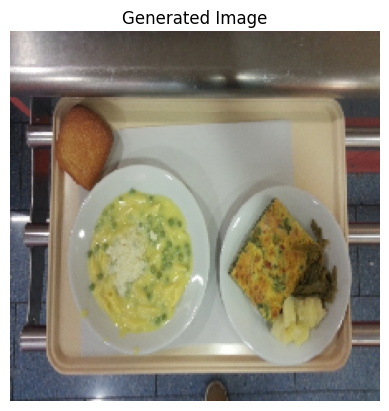

In [ ]:
import matplotlib.pyplot as plt

# Asumiendo que 'add_noise' está definida correctamente o se ha omitido de ImageDataGenerator
# Visualizar una imagen del generador
x, y = next(train_generator)  # Obtener un lote de imágenes y etiquetas
image = x[0]  # Seleccionar la primera imagen del lote

# Visualizar la imagen
plt.figure()
plt.imshow(image)
plt.title("Generated Image")
plt.axis('off')  # Omitir los ejes para una mejor visualización
plt.show()


## **Modelo**

En esta seccion se han configurado los diferentes modelos realizando las pruebas oportunas. Están las 3 aproximaciones.

### RESNET CONF 1

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
def build_resnet50(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    #Congelamos todas las capas
    base_model.trainable = True

    x = Flatten()(base_model.output)
    x = Dense(1028, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_initializer=HeNormal(),kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=base_model.input, outputs=x)

    rmse = tf.keras.metrics.RootMeanSquaredError()
    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mean_squared_error', metrics =[rmse])
    #model.compile(optimizer=Adam(learning_rate=0.001), loss=rmse, metrics=[rmse])

    return model
# Asumiendo que las imágenes se han redimensionado a 224x224
input_shape = (640, 480, 3)  # Altura, Anchura, Canales de Color
model = build_resnet50(input_shape)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_16 (ZeroPad  (None, 230, 230, 3)          0         ['input_11[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_16[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

### RESNET CONF 2

In [ ]:
def build_resnet50(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # Desbloquear algunas capas superiores del modelo base
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    #Capas de regresión
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', kernel_initializer=HeNormal())(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_initializer=HeNormal())(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='linear', kernel_regularizer=l2(0.01))(x)
    model = Model(inputs=base_model.input, outputs=x)

    rmse = tf.keras.metrics.RootMeanSquaredError()
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=[rmse, 'mae'])

    return model

input_shape = (224, 224, 3)  # Altura, Anchura, Canales de Color
model = build_resnet50(input_shape)
model.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_22[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

### EfficientNet

In [ ]:
def build_efficientnet_model(input_shape, num_outputs=1):
    # Cargar el modelo base EfficientNet preentrenado desde TensorFlow Hub
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    for layer in base_model.layers[-10:]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])

    return model

# Define el tamaño de entrada y construye el modelo
input_shape = (224, 224, 3)  # Asegúrate de que este tamaño sea compatible con EfficientNet
eff_model = build_efficientnet_model(input_shape)

# Compilar el modelo
eff_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Ver el resumen del modelo
eff_model.summary()


16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
def build_densenet(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    #Congelamos todas las capas
    base_model.trainable=False


    x = Flatten()(base_model.output)
    x = Dense(1028, activation='relu', kernel_initializer=HeNormal())(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_initializer=HeNormal())(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_initializer=HeNormal())(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_initializer=HeNormal())(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='linear', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=base_model.input, outputs=x)

    rmse = tf.keras.metrics.RootMeanSquaredError()
    model.compile(optimizer=Adam(learning_rate=0.001), loss = root_mean_squared_error, metrics =[rmse])
    #model.compile(optimizer=Adam(learning_rate=0.001), loss=rmse, metrics=[rmse])

    return model
# Asumiendo que las imágenes se han redimensionado a 224x224
input_shape = (224, 224, 3)  # Altura, Anchura, Canales de Color
model = build_densenet(input_shape)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, 230, 230, 3)          0         ['input_10[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_18[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

## **Entrenamiento**

Aqui se configuran tanto el Early Stopping como el ReduceLR para posteriormente usarlos en los entrenamientos de los diferentes modelos.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [ ]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00000001)


Se entrenan las diferentes configuraciones quedandonos con la mejor ejecución de cada uno.

### Entrenamiento ResNet Config 1


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=500,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
21/22 [===========================>..] - ETA: 0s - loss: 148.8401 - root_mean_squared_error: 10.1722

In [ ]:
model.save('content/resnet1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Entrenamiento Resnet Config 2


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=500,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
22/22 [==============================] - 20s 548ms/step - loss: 52.6338 - root_mean_squared_error: 7.2535 - mae: 5.8233 - val_loss: 11388.2695 - val_root_mean_squared_error: 106.7157 - val_mae: 105.2005 - lr: 0.0010
Epoch 2/500
22/22 [==============================] - 11s 500ms/step - loss: 36.4095 - root_mean_squared_error: 6.0324 - mae: 4.8856 - val_loss: 1627.3376 - val_root_mean_squared_error: 40.3400 - val_mae: 38.9858 - lr: 0.0010
Epoch 3/500
22/22 [==============================] - 12s 556ms/step - loss: 32.9525 - root_mean_squared_error: 5.7388 - mae: 4.5977 - val_loss: 100.7530 - val_root_mean_squared_error: 10.0366 - val_mae: 8.6155 - lr: 0.0010
Epoch 4/500
22/22 [==============================] - 12s 566ms/step - loss: 31.7291 - root_mean_squared_error: 5.6312 - mae: 4.5034 - val_loss: 55.0310 - val_root_mean_squared_error: 7.4170 - val_mae: 6.1868 - lr: 0.0010
Epoch 5/500
22/22 [==============================] - 15s 678ms/step - loss: 31.3755 - root_mean_squared

In [ ]:
model.save('content/modelo_resnet_finetuning.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Eff Entrenamiento

In [ ]:
history = eff_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=500,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
22/22 [==============================] - 68s 977ms/step - loss: 58.8703 - root_mean_squared_error: 7.6715 - val_loss: 43.5989 - val_root_mean_squared_error: 6.6016 - lr: 0.0010
Epoch 2/500
22/22 [==============================] - 16s 736ms/step - loss: 24.3737 - root_mean_squared_error: 4.9352 - val_loss: 19.2505 - val_root_mean_squared_error: 4.3856 - lr: 0.0010
Epoch 3/500
22/22 [==============================] - 17s 777ms/step - loss: 18.3869 - root_mean_squared_error: 4.2860 - val_loss: 24.6646 - val_root_mean_squared_error: 4.9646 - lr: 0.0010
Epoch 4/500
22/22 [==============================] - 17s 761ms/step - loss: 17.0862 - root_mean_squared_error: 4.1315 - val_loss: 13.5261 - val_root_mean_squared_error: 3.6755 - lr: 0.0010
Epoch 5/500
22/22 [==============================] - 16s 739ms/step - loss: 12.8135 - root_mean_squared_error: 3.5773 - val_loss: 14.4770 - val_root_mean_squared_error: 3.8027 - lr: 0.0010
Epoch 6/500
22/22 [==============================] - 17

In [ ]:
model.save('content/modelo_effnet.h5')

## **Evaluación**

### Eval ResNet Config 1

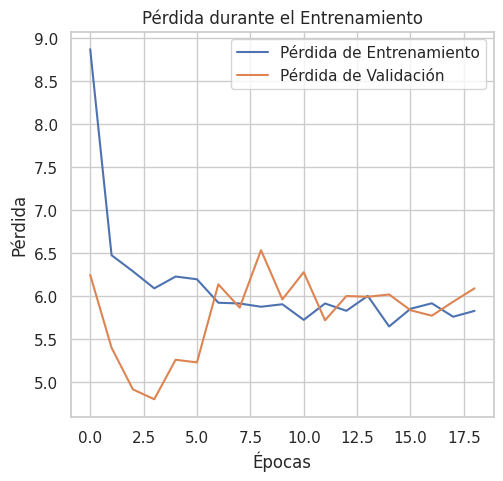

In [ ]:
# Gráfico de pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['root_mean_squared_error'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_root_mean_squared_error'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


### Eval ResNet Config 2


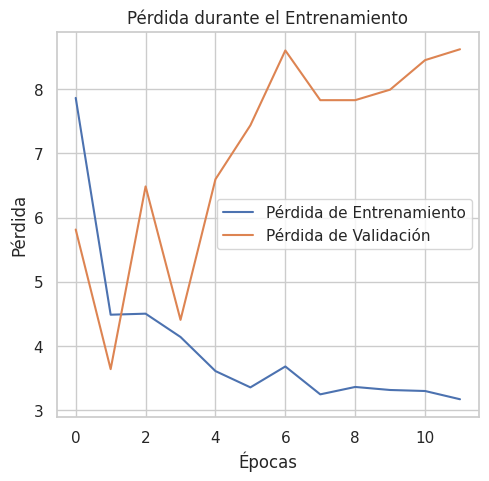

In [ ]:
# Gráfico de pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['root_mean_squared_error'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_root_mean_squared_error'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


### Eval EffNet

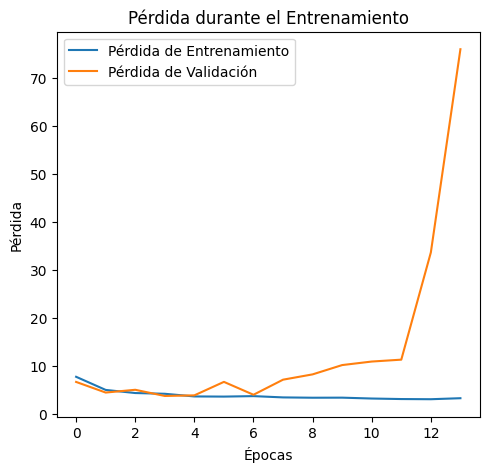

In [ ]:
# Gráfico de pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['root_mean_squared_error'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_root_mean_squared_error'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

## **Test**

En esta seccion se prueba el modelo ya entrenado con el conjunto de test. Se puede observar que la mejor prediccion es la de la segunda aproximación.

### Test RestNet Config 1

Found 155 validated image filenames.
155/155 [==============================] - 4s 12ms/step
RMSE: 12.076735130427236
1/1 [==============================] - 0s 25ms/step


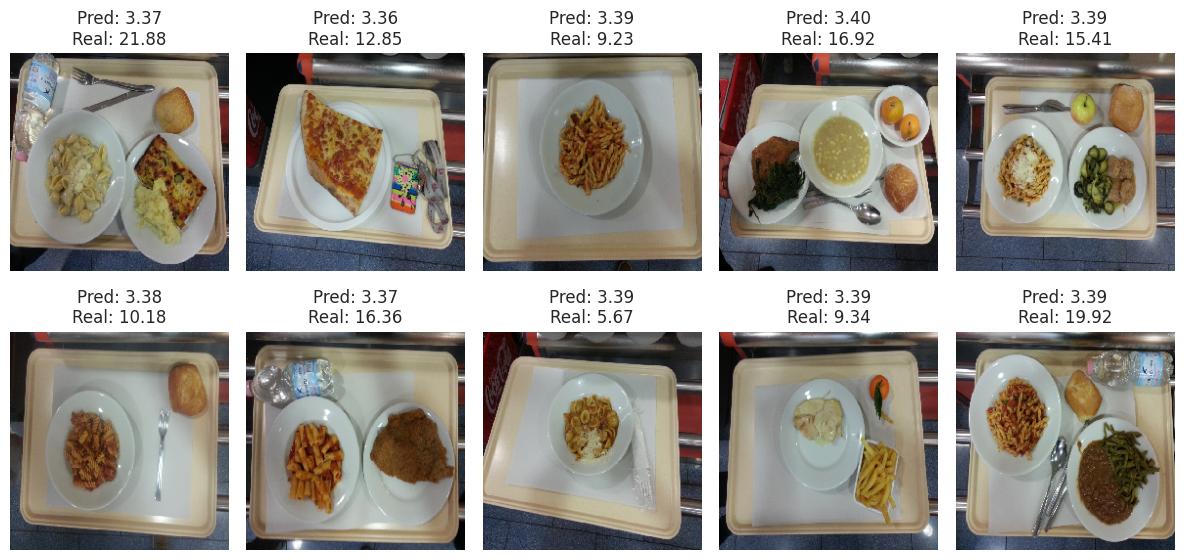

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from math import sqrt
from sklearn.metrics import mean_squared_error

# Cargar el modelo entrenado
# Asegúrate de proporcionar la ruta correcta a tu modelo guardado
#model = load_model('ruta/a/tu/modelo.h5')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_folder_path,  # Asegúrate de que esta ruta sea correcta
    x_col='image_name',
    y_col='food_pixels',
    target_size=(224, 224),  # Asegúrate de que este tamaño sea el correcto para tu modelo
    batch_size=1,  # Procesar una imagen a la vez
    class_mode='raw',  # 'raw' porque es un problema de regresión
    shuffle=False  # Importante: mantener el orden para comparar con las etiquetas verdaderas
)

# Predecir los valores para las imágenes de test
predictions = model.predict(test_generator, steps=len(test_generator))

# Obtener los valores verdaderos de las etiquetas
true_values = test_generator.labels

# Calcular RMSE
rmse = sqrt(mean_squared_error(true_values, predictions))

print(f'RMSE: {rmse}')

# Opcional: Visualizar algunas predicciones
plt.figure(figsize=(12, 6))
for i in range(10):  # Ajusta el rango para ver más o menos predicciones
    plt.subplot(2, 5, i+1)
    img, label = test_generator.next()
    pred = model.predict(img)
    plt.imshow(img[0])
    plt.title(f'Pred: {pred[0][0]:.2f}\nReal: {label[0]:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Test Resnet Config 2

Found 155 validated image filenames.
155/155 [==============================] - 2s 10ms/step
RMSE: 4.688967405190209
1/1 [==============================] - 0s 32ms/step


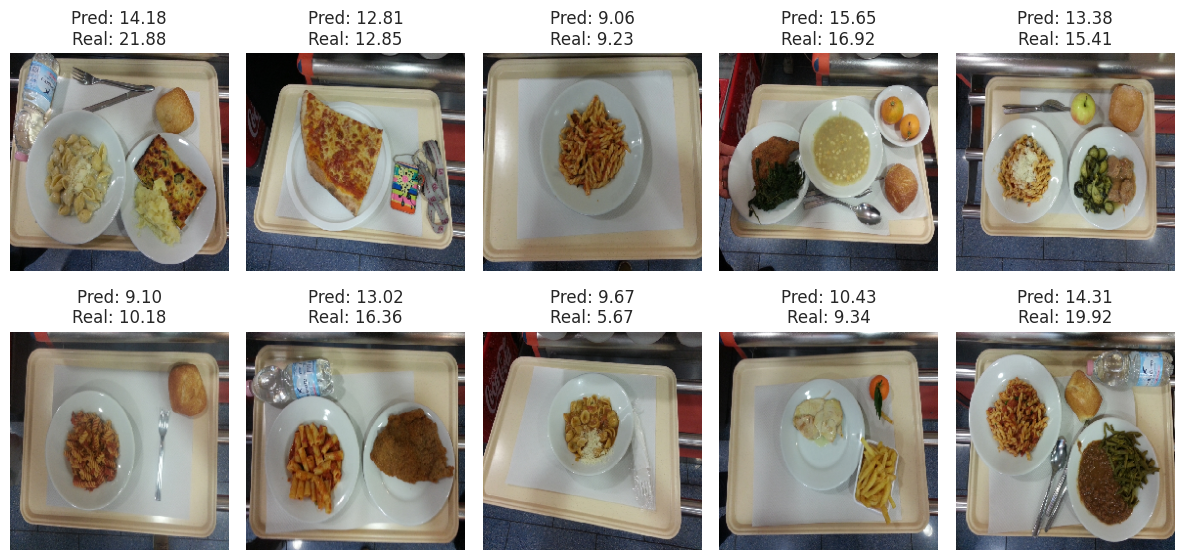

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from math import sqrt
from sklearn.metrics import mean_squared_error

# Cargar el modelo entrenado
# Asegúrate de proporcionar la ruta correcta a tu modelo guardado
#model = load_model('ruta/a/tu/modelo.h5')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_folder_path,  # Asegúrate de que esta ruta sea correcta
    x_col='image_name',
    y_col='food_pixels',
    target_size=(224, 224),  # Asegúrate de que este tamaño sea el correcto para tu modelo
    batch_size=1,  # Procesar una imagen a la vez
    class_mode='raw',  # 'raw' porque es un problema de regresión
    shuffle=False  # Importante: mantener el orden para comparar con las etiquetas verdaderas
)

# Predecir los valores para las imágenes de test
predictions = model.predict(test_generator, steps=len(test_generator))

# Obtener los valores verdaderos de las etiquetas
true_values = test_generator.labels

# Calcular RMSE
rmse = sqrt(mean_squared_error(true_values, predictions))

print(f'RMSE: {rmse}')

# Opcional: Visualizar algunas predicciones
plt.figure(figsize=(12, 6))
for i in range(10):  # Ajusta el rango para ver más o menos predicciones
    plt.subplot(2, 5, i+1)
    img, label = test_generator.next()
    pred = model.predict(img)
    plt.imshow(img[0])
    plt.title(f'Pred: {pred[0][0]:.2f}\nReal: {label[0]:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Test Eff net

Found 155 validated image filenames.
155/155 [==============================] - 4s 24ms/step
RMSE: 12.767770040008049
1/1 [==============================] - 0s 28ms/step


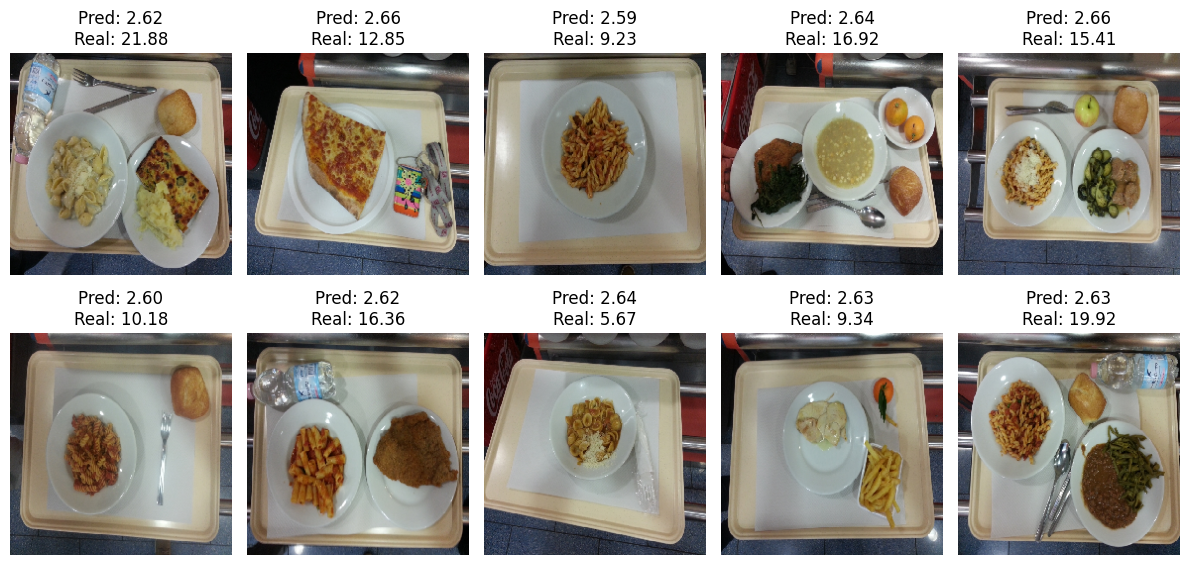

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from math import sqrt
from sklearn.metrics import mean_squared_error

# Cargar el modelo entrenado
# Asegúrate de proporcionar la ruta correcta a tu modelo guardado
#model = load_model('ruta/a/tu/modelo.h5')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_folder_path,  # Asegúrate de que esta ruta sea correcta
    x_col='image_name',
    y_col='food_pixels',
    target_size=(224, 224),  # Asegúrate de que este tamaño sea el correcto para tu modelo
    batch_size=1,  # Procesar una imagen a la vez
    class_mode='raw',  # 'raw' porque es un problema de regresión
    shuffle=False  # Importante: mantener el orden para comparar con las etiquetas verdaderas
)

# Predecir los valores para las imágenes de test
predictions = eff_model.predict(test_generator, steps=len(test_generator))

# Obtener los valores verdaderos de las etiquetas
true_values = test_generator.labels

# Calcular RMSE
rmse = sqrt(mean_squared_error(true_values, predictions))

print(f'RMSE: {rmse}')

# Opcional: Visualizar algunas predicciones
plt.figure(figsize=(12, 6))
for i in range(10):  # Ajusta el rango para ver más o menos predicciones
    plt.subplot(2, 5, i+1)
    img, label = test_generator.next()
    pred = eff_model.predict(img)
    plt.imshow(img[0])
    plt.title(f'Pred: {pred[0][0]:.2f}\nReal: {label[0]:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()